In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sn
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn import metrics
import xgboost as xgb

from comet_ml import Experiment
from tidyData import tidy_data, split_data

sn.set_theme()

In [2]:
df = tidy_data('../data')
# df.to_csv('data_for_adv.csv')
# df = pd.read_csv('data_for_adv.csv', index_col='index')
# df = df.drop(columns='Unnamed: 0')
# df['season'] = df['season'].astype('str')
# df = df[df['shotType'].notna()]
print(len(df))

/Users/subhrajyotidasgupta/Downloads/Mila:UdeM/IFT6758/DS project/IFT6758_Project_Milestone-1/Milestone2/tidyData.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(np.abs(y) / abs(x-89))
/Users/subhrajyotidasgupta/Downloads/Mila:UdeM/IFT6758/DS project/IFT6758_Project_Milestone-1/Milestone2/tidyData.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  angle=np.arctan(np.abs(y) / abs(x+89))


409341


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409341 entries, 0 to 409340
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index                          409341 non-null  int64  
 1   gameID_eventID                 409341 non-null  object 
 2   game_period                    409341 non-null  int64  
 3   dateTime                       409341 non-null  object 
 4   gameID                         409341 non-null  int64  
 5   team                           409341 non-null  object 
 6   goal                           409341 non-null  int64  
 7   x                              409341 non-null  object 
 8   y                              409341 non-null  object 
 9   shooter                        409341 non-null  object 
 10  goalie                         409341 non-null  object 
 11  shotType                       409295 non-null  object 
 12  emptyNet                      

In [4]:
train_val_df, test_df = split_data(df)

## Selecting only the columns from Q4
columns = ['game_period', 'x', 'y', 'distanceNet_or_shotDistance', 'goal', 'shot_angle_absolute', 
           'shotType', 'last_event', 'last_x', 'last_y', 'game_seconds', 'time_from_last_event', 
           'distance_from_last_event', 'rebound', 'speed', 'time_since_powerplay_started', 
           'nbFriendly_non_goalie_skaters', 'nbOpposing_non_goalie_skaters', 'change_in_shot_angle']

data = train_val_df[columns]


## Proper datatype casting of columns
cols_dtype_change = ['x', 'y', 'last_x', 'last_y', 'distance_from_last_event', 
                     'speed', 'sum_x', 'distanceNet_or_shotDistance']
for col in cols_dtype_change:
    if col in data.columns:
        data[col] = data[col].astype('float')
    if 'game_period' in data.columns:
        data['game_period'] = data['game_period'].astype('str')

        
cat_cols = data.select_dtypes(exclude="number").columns
num_cols = data.select_dtypes(include="number").columns


feature_n = columns[:]
feature_names = []
for feature in cat_cols:
    if feature in cat_cols:
        # print(data[feature].unique())
        if feature == 'shotType':
            # print(feature, len(train_val_df[feature].unique()) - 1)            
            feature_names.extend([feature]*(len(train_val_df[feature].unique()) - 1))
        else:
            # print(feature, len(train_val_df[feature].unique()))            
            feature_names.extend([feature]*(len(train_val_df[feature].unique())))            
    else:
        feature_names.append(feature)
        
# print(feature_names, len(feature_names))
num = SimpleImputer(strategy="mean").fit_transform(data[num_cols])
# num = StandardScaler().fit_transform(num)
cat = SimpleImputer(missing_values=None, strategy="most_frequent").fit_transform(data[cat_cols])
cat = OneHotEncoder(handle_unknown="ignore", sparse=False).fit_transform(cat)
data = pd.concat((pd.DataFrame(num, columns=list(num_cols)), 
                  pd.DataFrame(cat, columns=feature_names)), 
                  axis=1, names = list(num_cols).extend(list(cat_cols)))


## Train-val splitting
X_train, X_val, y_train, y_val = train_test_split(data.loc[::,data.columns!='goal'],
                                                 data[['goal']],
                                                 test_size=0.25,
                                                 random_state=10, 
                                                 shuffle = True)

dataset saved as <df_dataset.csv>
df_testset saved as <df_testset.csv>


/var/folders/hj/p60mmmm547bfmcg1d667q2d00000gn/T/ipykernel_22720/4088929006.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].astype('float')
/var/folders/hj/p60mmmm547bfmcg1d667q2d00000gn/T/ipykernel_22720/4088929006.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game_period'] = data['game_period'].astype('str')


## XGBoost Using only distance and angle

In [5]:
with open('COMET_API_KEY.txt', 'r') as f:
    key = f.read()
    
experiment = Experiment(
    api_key=key,
    project_name="nhl-analytics",
    workspace="ift6758-22-team2",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, xgboost. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-22-team2/nhl-analytics/9d331e535f2249598410afcac3517d08



In [6]:
xgb_da = xgb.XGBClassifier()

# Fit
xgb_da.fit(X_train[['distanceNet_or_shotDistance', 'shot_angle_absolute']].astype('float'), y_train)

# Predict
preds = xgb_da.predict(X_val[['distanceNet_or_shotDistance', 'shot_angle_absolute']].astype('float'))

experiment.log_metric('accuracy', accuracy_score(y_val, preds))
experiment.log_metric('f1 score', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score', roc_auc_score(y_val, preds))
# accuracy_score(y_val, preds)

In [7]:
predicted_prob_da = xgb_da.predict_proba(X_val[['distanceNet_or_shotDistance', 'shot_angle_absolute']].astype('float'))

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr_da = dict()
tpr_da = dict()
roc_auc_da = dict()

# Compute micro-average ROC curve and ROC area
fpr_da["micro"], tpr_da["micro"], _ = roc_curve(y_val, predicted_prob_da[:,1])
roc_auc_da["micro"] = auc(fpr_da["micro"], tpr_da["micro"])

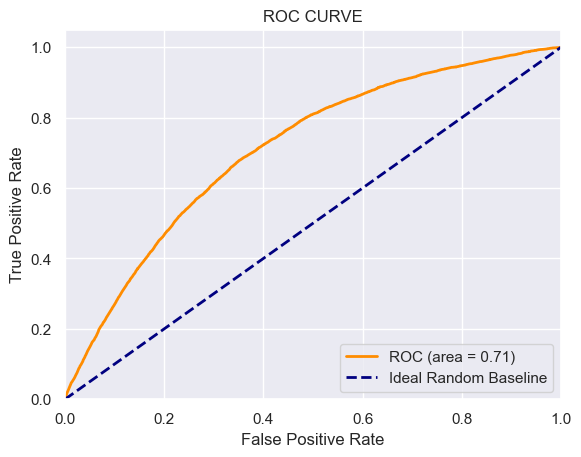

In [8]:
plt.figure()
lw = 2
plt.plot(
    fpr_da["micro"],
    tpr_da["micro"],
    color="darkorange",
    lw=lw,
    label="ROC (area = %0.2f)" % roc_auc_da["micro"],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, label="Ideal Random Baseline",linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right")
experiment.log_figure(figure_name='ROC Curve using Distance and Angle', step=None)
plt.show()

In [9]:
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))

df_prob_da = pd.DataFrame(list(zip(preds,y_val['goal'],predicted_prob_da[:,1]*100)), 
                          columns = ['goal_pred', 'goal','goal_Prob'])
df_prob_da['shot'] = 1
sum_goal = df_prob_da['goal'].sum()
df_prob_da['percentile'] = df_prob_da['goal_Prob'].rank(pct=True) * 100
df_prob_da['goal_perc_bins'] = pd.cut(df_prob_da['percentile'], bins, labels = bin_centers)
df_prob_bined_da = df_prob_da[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined_da['goal_rate'] = (df_prob_bined_da['goal']/df_prob_bined_da['shot'])
df_prob_bined_da['goal_cum'] = (df_prob_bined_da['goal']/sum_goal)
df_prob_bined_da['goal_cumsum'] = 1-df_prob_bined_da['goal_cum'].cumsum()

/var/folders/hj/p60mmmm547bfmcg1d667q2d00000gn/T/ipykernel_22720/2147607427.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'web': 'https://www.comet.com/api/image/download?imageId=0f79da6190514df8b1885a1672cb1a4d&experimentKey=9d331e535f2249598410afcac3517d08',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0f79da6190514df8b1885a1672cb1a4d&experimentKey=9d331e535f2249598410afcac3517d08',
 'imageId': '0f79da6190514df8b1885a1672cb1a4d'}

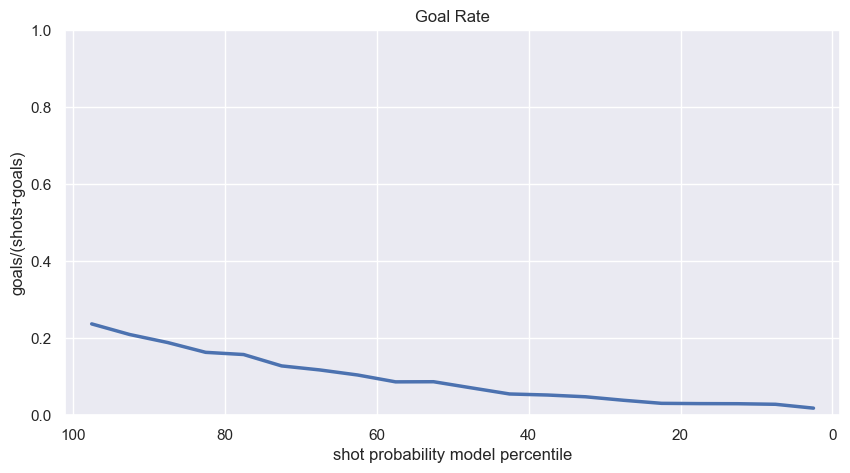

In [10]:
fig = plt.figure(figsize = (10,5))
plt.title(f"Goal Rate")
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined_da, legend = False, linewidth = 2.5)
plt.xlabel('shot probability model percentile')
plt.ylabel('goals/(shots+goals)')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,120,20))
fig.show()
experiment.log_figure(figure_name='Goal Rate using Distance and Angle', step=None)

/var/folders/hj/p60mmmm547bfmcg1d667q2d00000gn/T/ipykernel_22720/4127515970.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'web': 'https://www.comet.com/api/image/download?imageId=9bf6712bde234e59858ff3763f588d93&experimentKey=9d331e535f2249598410afcac3517d08',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=9bf6712bde234e59858ff3763f588d93&experimentKey=9d331e535f2249598410afcac3517d08',
 'imageId': '9bf6712bde234e59858ff3763f588d93'}

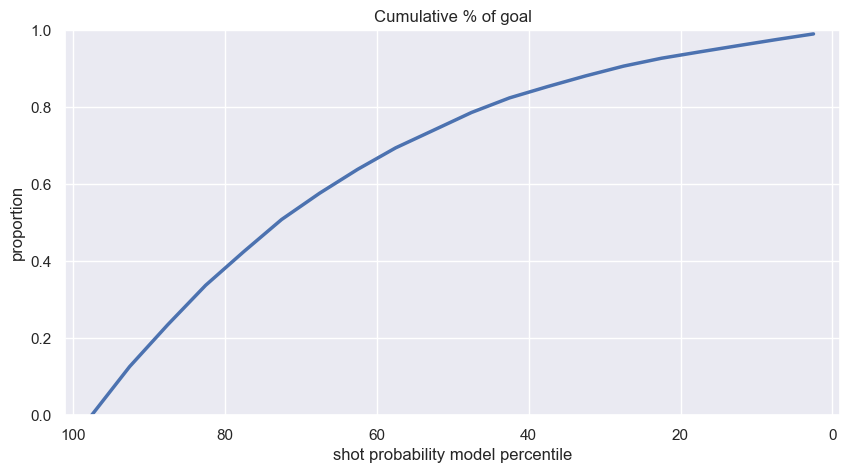

In [11]:
fig = plt.figure(figsize = (10,5))
plt.title(f"Cumulative % of goal")
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined_da, legend = False, linewidth = 2.5)
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,120,20))
fig.show()
experiment.log_figure(figure_name='Cumulative goal % using Distance and Angle', step=None)

/var/folders/hj/p60mmmm547bfmcg1d667q2d00000gn/T/ipykernel_22720/2140477529.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'web': 'https://www.comet.com/api/image/download?imageId=75d93540c9cd4d83b43fa0340e2fc525&experimentKey=9d331e535f2249598410afcac3517d08',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=75d93540c9cd4d83b43fa0340e2fc525&experimentKey=9d331e535f2249598410afcac3517d08',
 'imageId': '75d93540c9cd4d83b43fa0340e2fc525'}

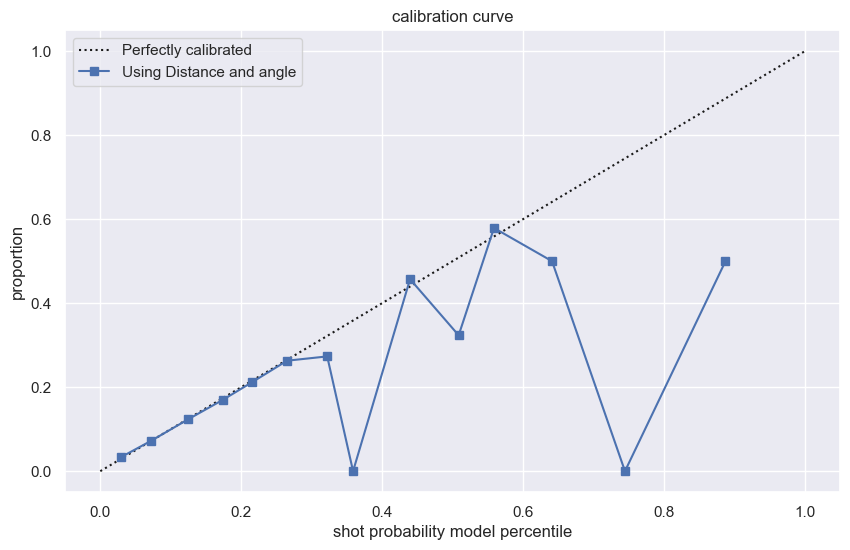

In [12]:
fig = plt.figure(figsize = (10,6))
plt.title(f"calibration curve")
prob_true_da, prob_pred_da = calibration_curve(df_prob_da['goal'], df_prob_da['goal_Prob']/100, n_bins=20)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(prob_pred_da, prob_true_da, "s-",label='Using Distance and angle')
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
plt.legend(loc="upper left")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,1.2,0.2))
plt.yticks(np.arange(0,1.2,0.2))
fig.show()
experiment.log_figure(figure_name='Calibration curve using Distance and Angle', step=None)

In [13]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-22-team2/nhl-analytics/9d331e535f2249598410afcac3517d08
COMET INFO:   Metrics:
COMET INFO:     ROC AUC score : 0.5014609134419324
COMET INFO:     accuracy      : 0.9058401481252893
COMET INFO:     f1 score      : 0.006781500067815
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures                      : 4
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (68.97 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                  

## Using all columns from Q4

In [14]:
experiment = Experiment(
    api_key=key,
    project_name="nhl-analytics",
    workspace="ift6758-22-team2",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, xgboost. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-22-team2/nhl-analytics/4dbbaa9347834df9872defc89fb3e7cc



In [15]:
xgb_all = xgb.XGBClassifier()

# Fit
xgb_all.fit(X_train.values, y_train)

# Predict
preds = xgb_all.predict(X_val)

experiment.log_metric('accuracy with all features', accuracy_score(y_val, preds))
experiment.log_metric('f1 score with all features', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score with all features', roc_auc_score(y_val, preds))
# accuracy_score(y_val, preds)

In [18]:
# xgb_all.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

## Hyperparam Tuning

### Tuning `eta/learning rate`

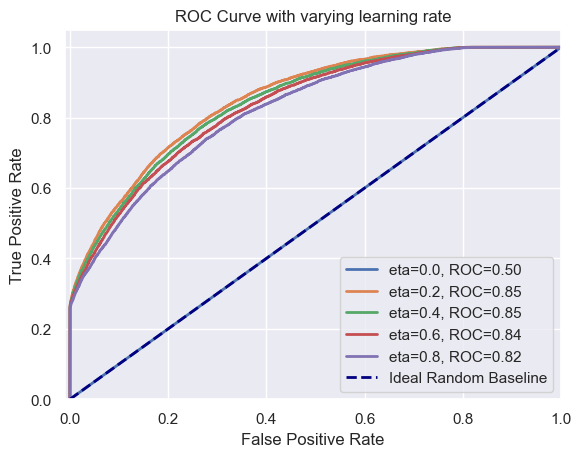

In [16]:
roc_eta = []

for eta in np.arange(0.0, 1.0, .2):
    model = xgb.XGBClassifier(eta= eta, max_depth= 7)
    model.fit(X_train.values, y_train)

    predicted_prob = model.predict_proba(X_val.values)

    # Compute ROC curve and ROC area for each class
    n_classes = 2
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val, predicted_prob[:,1])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_eta.append((fpr["micro"], tpr["micro"], eta, roc_auc["micro"]))
    
lw = 2
plt.plot(roc_eta[0][0],roc_eta[0][1],lw=lw,label="eta=%0.1f, ROC=%0.2f" % (roc_eta[0][2], roc_eta[0][3]))
plt.plot(roc_eta[1][0],roc_eta[1][1],lw=lw,label="eta=%0.1f, ROC=%0.2f" % (roc_eta[1][2], roc_eta[1][3]))
plt.plot(roc_eta[2][0],roc_eta[2][1],lw=lw,label="eta=%0.1f, ROC=%0.2f" % (roc_eta[2][2], roc_eta[2][3]))
plt.plot(roc_eta[3][0],roc_eta[3][1],lw=lw,label="eta=%0.1f, ROC=%0.2f" % (roc_eta[3][2], roc_eta[3][3]))
plt.plot(roc_eta[4][0],roc_eta[4][1],lw=lw,label="eta=%0.1f, ROC=%0.2f" % (roc_eta[4][2], roc_eta[4][3]))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, label="Ideal Random Baseline",linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with varying learning rate")
plt.legend(loc="lower right")
experiment.log_figure(figure_name='ROC Curve with varying learning rate', step=None)
plt.savefig('cv_roc_1.png')
plt.show()

### Tuning `booster`

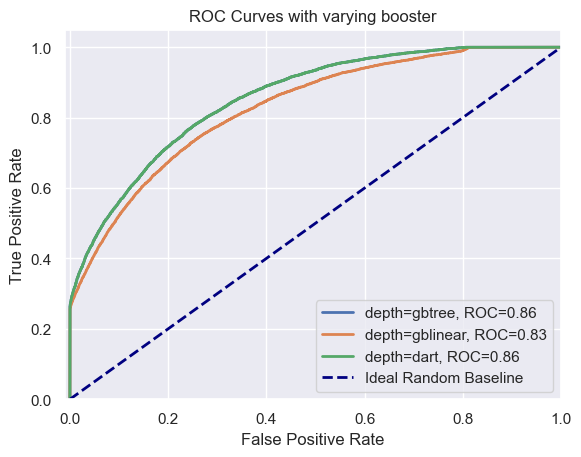

In [17]:
roc_booster = []

for booster in ['gbtree', 'gblinear', 'dart']:
    model = xgb.XGBClassifier(eta= 0.1, booster= booster)
    model.fit(X_train.values, y_train)

    predicted_prob = model.predict_proba(X_val.values)

    # Compute ROC curve and ROC area for each class
    n_classes = 2
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val, predicted_prob[:,1])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_booster.append((fpr["micro"], tpr["micro"], booster, roc_auc["micro"]))
    
# plt.figure()
lw = 2
plt.plot(roc_booster[0][0],roc_booster[0][1],lw=lw,label="depth=%s, ROC=%0.2f" % (roc_booster[0][2], roc_booster[0][3]))
plt.plot(roc_booster[1][0],roc_booster[1][1],lw=lw,label="depth=%s, ROC=%0.2f" % (roc_booster[1][2], roc_booster[1][3]))
plt.plot(roc_booster[2][0],roc_booster[2][1],lw=lw,label="depth=%s, ROC=%0.2f" % (roc_booster[2][2], roc_booster[2][3]))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, label="Ideal Random Baseline",linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with varying booster")
plt.legend(loc="lower right")
experiment.log_figure(figure_name='ROC Curves with varying booster', step=None)
plt.savefig('cv_roc_2.png')
plt.show()

In [ ]:
model.

## Grid Search Hyperparam tuning

In [19]:
from sklearn.model_selection import GridSearchCV

xgb_cv = xgb.XGBClassifier()

param_grid = {
    'eta': [0.1, 0.2, 0.4],
    'max_depth': [5, 6, 7],
    'subsample': [0.6, 0.8, 1.0],
    'booster': ['gbtree', 'gblinear']
}
search = GridSearchCV(xgb_cv, param_grid, n_jobs=2, scoring='roc_auc', verbose=2)
search.fit(X_train.values, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.6; total time=  13.8s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.6; total time=  13.0s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.6; total time=  14.2s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.8; total time=  14.3s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.8; total time=  14.8s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=1.0; total time=  14.2s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=1.0; total time=  15.4s
[CV] END booster=gbtree, eta=0.1, max_depth=6, subsample=0.6; total time=  20.5s
[CV] END booster=gbtree, eta=0.1, max_depth=6, subsample=0.6; total time=  19.9s
[CV] END booster=gbtree, eta=0.1, max_depth=6, subsample=0.6; total time=  19.7s
[CV] END booster=gbtree, eta=0.1, max_depth=6, subsample=0.8; total time=  19.8s
[CV] END booster=gbtree, eta=0.1, max_depth=6, 

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=2,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'eta': [0.1, 0.2, 0.4], 'max_depth': [5, 6, 7],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [20]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.858):
{'booster': 'gbtree', 'eta': 0.1, 'max_depth': 7, 'subsample': 0.8}


In [21]:
xgb_all_cv = xgb.XGBClassifier(eta= 0.1, max_depth= 7, subsample= 0.8)

# Fit
xgb_all_cv.fit(X_train.values, y_train)

# Predict
preds = xgb_all_cv.predict(X_val)

experiment.log_metric('accuracy after cross-val', accuracy_score(y_val, preds))
experiment.log_metric('f1 score after cross-val', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score after cross-val', roc_auc_score(y_val, preds))
# accuracy_score(y_val, preds)

[02:59:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[CV] END booster=gblinear, eta=0.2, max_depth=6, subsample=1.0; total time=   2.4s
[02:59:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[CV] END booster=gblinear, eta=0.2, max_depth=7, subsample=0.6; total time=   2.2s
[02:59:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "subsample" } are not used.

[CV] END booster=gblinear, eta=0.2, max_depth=7, subsample=0.6; total time=   2.4s
[02:59:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", 

In [35]:
# xgb_all_best.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.200000003,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 5,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eta': 0.2}

In [22]:
predicted_prob_cv = xgb_all_cv.predict_proba(X_val.values)

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr_cv = dict()
tpr_cv = dict()
roc_auc_cv = dict()

# Compute micro-average ROC curve and ROC area
fpr_cv["micro"], tpr_cv["micro"], _ = roc_curve(y_val, predicted_prob_cv[:,1])
roc_auc_cv["micro"] = auc(fpr_cv["micro"], tpr_cv["micro"])

# Compute goal rate and cumulative goal rate
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))

df_prob_cv = pd.DataFrame(list(zip(preds,y_val['goal'],predicted_prob_cv[:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
df_prob_cv['shot'] = 1
sum_goal = df_prob_cv['goal'].sum()
df_prob_cv['percentile'] = df_prob_cv['goal_Prob'].rank(pct=True) * 100
df_prob_cv['goal_perc_bins'] = pd.cut(df_prob_cv['percentile'], bins, labels = bin_centers)
df_prob_bined_cv = df_prob_cv[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined_cv['goal_rate'] = (df_prob_bined_cv['goal']/df_prob_bined_cv['shot'])
df_prob_bined_cv['goal_cum'] = (df_prob_bined_cv['goal']/sum_goal)
df_prob_bined_cv['goal_cumsum'] = 1-df_prob_bined_cv['goal_cum'].cumsum()

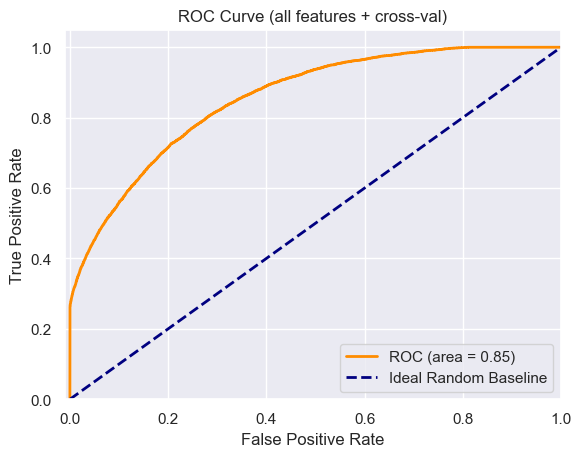

In [24]:
plt.figure()
lw = 2
plt.plot(
    fpr_cv["micro"],
    tpr_cv["micro"],
    color="darkorange",
    lw=lw,
    label="ROC (area = %0.2f)" % roc_auc_cv["micro"],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, label="Ideal Random Baseline",linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (all features + cross-val)")
plt.legend(loc="lower right")
experiment.log_figure(figure_name='ROC Curve (all features + cross-val)', step=None)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/hj/p60mmmm547bfmcg1d667q2d00000gn/T/ipykernel_22720/3490740877.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'web': 'https://www.comet.com/api/image/download?imageId=ab2591b2516d43ad9e14b27bdd0c8841&experimentKey=4dbbaa9347834df9872defc89fb3e7cc',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ab2591b2516d43ad9e14b27bdd0c8841&experimentKey=4dbbaa9347834df9872defc89fb3e7cc',
 'imageId': 'ab2591b2516d43ad9e14b27bdd0c8841'}

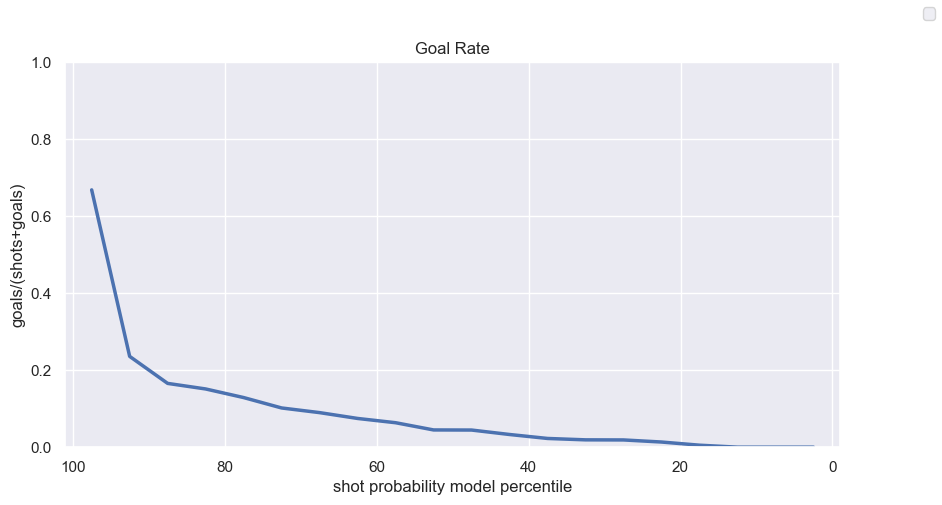

In [25]:
fig = plt.figure(figsize = (10,5))
plt.title(f"Goal Rate")
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined_cv, legend = False, linewidth = 2.5)
fig.legend(loc="upper right")
plt.xlabel('shot probability model percentile')
plt.ylabel('goals/(shots+goals)')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,120,20))
fig.show()
experiment.log_figure(figure_name='Goal rate (all features + cross-val)', step=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/hj/p60mmmm547bfmcg1d667q2d00000gn/T/ipykernel_22720/3286542252.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'web': 'https://www.comet.com/api/image/download?imageId=9cf3fbf99cd24d0d861f95b6ef39e199&experimentKey=4dbbaa9347834df9872defc89fb3e7cc',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=9cf3fbf99cd24d0d861f95b6ef39e199&experimentKey=4dbbaa9347834df9872defc89fb3e7cc',
 'imageId': '9cf3fbf99cd24d0d861f95b6ef39e199'}

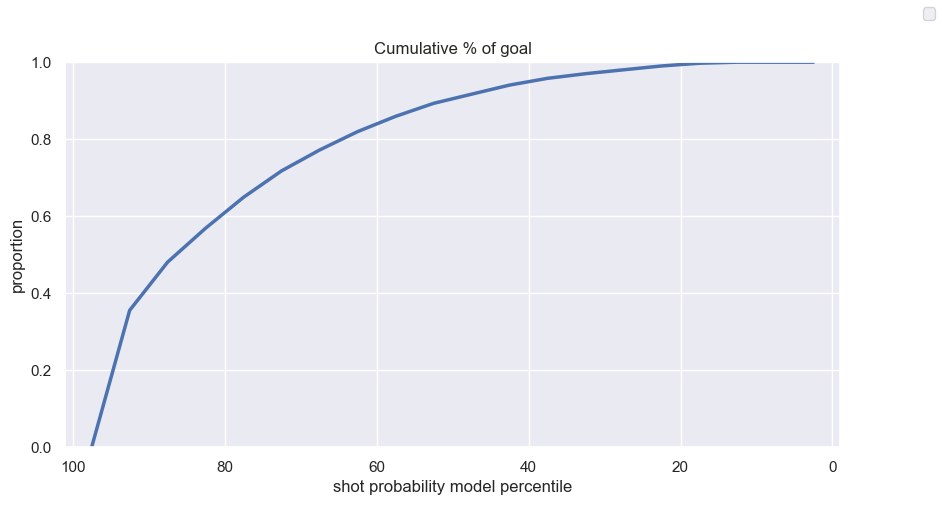

In [26]:
fig = plt.figure(figsize = (10,5))
plt.title(f"Cumulative % of goal")
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined_cv, legend = False, linewidth = 2.5)
fig.legend(loc="upper right")
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,120,20))
fig.show()
experiment.log_figure(figure_name='Cumulative goal % (all features + cross-val)', step=None)

/var/folders/hj/p60mmmm547bfmcg1d667q2d00000gn/T/ipykernel_22720/3146907444.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'web': 'https://www.comet.com/api/image/download?imageId=6071220da1f7439c8ad9172543e10ff2&experimentKey=4dbbaa9347834df9872defc89fb3e7cc',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=6071220da1f7439c8ad9172543e10ff2&experimentKey=4dbbaa9347834df9872defc89fb3e7cc',
 'imageId': '6071220da1f7439c8ad9172543e10ff2'}

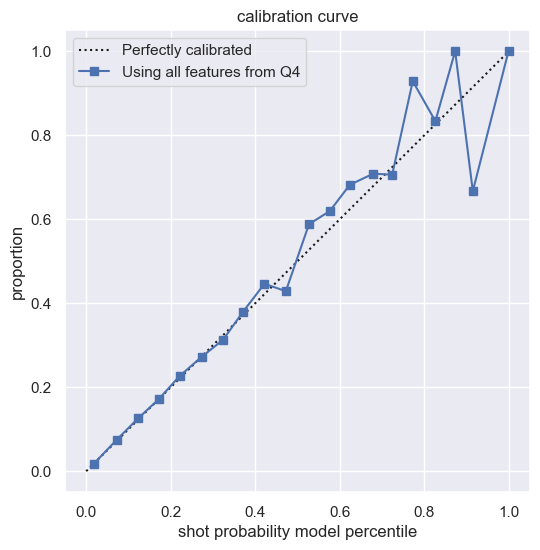

In [27]:
fig = plt.figure(figsize = (6,6))
plt.title(f"calibration curve")
prob_true_cv, prob_pred_cv = calibration_curve(df_prob_cv['goal'], df_prob_cv['goal_Prob']/100, n_bins=20)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(prob_pred_cv, prob_true_cv, "s-",label='Using all features from Q4')
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
plt.legend(loc="upper left")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,1.2,0.2))
plt.yticks(np.arange(0,1.2,0.2))
fig.show()
experiment.log_figure(figure_name='Calibration Curve (all features + cross-val)', step=None)

In [29]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
pickle.dump(xgb_all_cv, open('models/xgb_all_cv.sav', 'wb'))
experiment.log_model("XGB_all_cv", 'models/xgb_all_cv.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=dd345ff4558848dab3bfa540662ea465&experimentKey=4dbbaa9347834df9872defc89fb3e7cc',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=dd345ff4558848dab3bfa540662ea465&experimentKey=4dbbaa9347834df9872defc89fb3e7cc',
 'assetId': 'dd345ff4558848dab3bfa540662ea465'}

In [30]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-22-team2/nhl-analytics/4dbbaa9347834df9872defc89fb3e7cc
COMET INFO:   Metrics:
COMET INFO:     ROC AUC score after cross-val   : 0.633832435545457
COMET INFO:     ROC AUC score with all features : 0.6391207884984339
COMET INFO:     accuracy after cross-val        : 0.9306305611273981
COMET INFO:     accuracy with all features      : 0.9305534125392172
COMET INFO:     f1 score after cross-val        : 0.42107522266337594
COMET INFO:     f1 score with all features      : 0.4314138330350563
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures             

## Feature Selection

In [31]:
experiment = Experiment(
    api_key=key,
    project_name="nhl-analytics",
    workspace="ift6758-22-team2",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, xgboost. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-22-team2/nhl-analytics/5a0f6b7429074bd6adf056f184519c30



### Explainability of features using SHAP

In [32]:
# fix for waterfall shap plots - https://github.com/slundberg/shap/issues/2471
import inspect
import shap.plots._waterfall
source = inspect.getsource(shap.plots._waterfall)
new_source = source.replace("as pl", "as plt")
exec(new_source, shap.plots._waterfall.__dict__)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


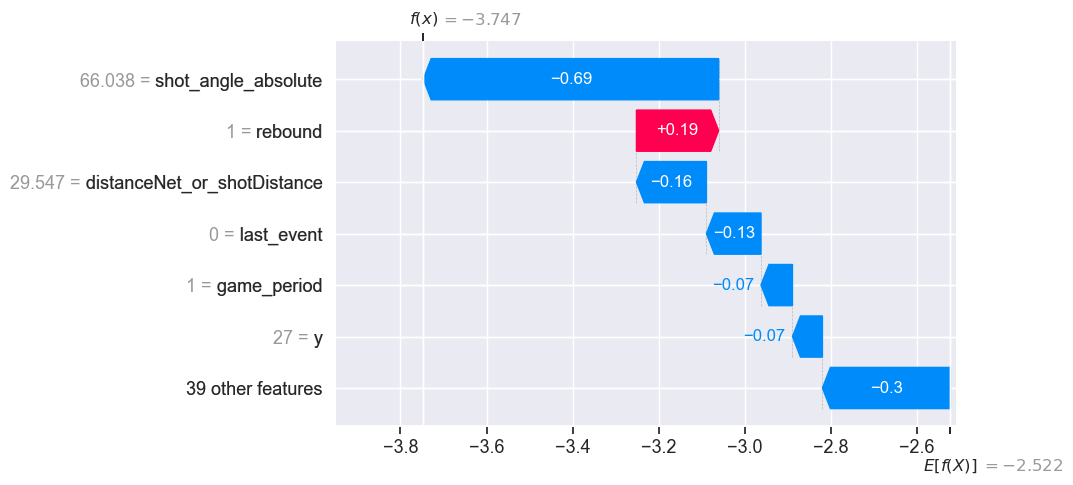

In [33]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_all_cv) 
# shap_values = explainer(data.loc[::,data.columns!='goal'].loc[::,selector.get_support()])
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=7, show=False)
experiment.log_figure(figure_name='SHAP Features')
plt.show()

### Using Variance Threshold feature selection

In [34]:
roc_list = []

In [35]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
features = selector.fit_transform(X_train)
val_features = selector.transform(X_val)

print('Selected Features: ', set(X_train.columns[selector.get_support()]))

Selected Features:  {'change_in_shot_angle', 'time_since_powerplay_started', 'time_from_last_event', 'shotType', 'nbFriendly_non_goalie_skaters', 'last_event', 'nbOpposing_non_goalie_skaters', 'distanceNet_or_shotDistance', 'last_y', 'x', 'y', 'game_period', 'game_seconds', 'shot_angle_absolute', 'speed', 'last_x', 'distance_from_last_event'}


In [36]:
xgb_var_th = xgb.XGBClassifier(eta= 0.3, max_depth=5)

# Fit
xgb_var_th.fit(features, y_train)

# Predict
preds = xgb_var_th.predict(val_features)

experiment.log_metric('accuracy with var threshold', accuracy_score(y_val, preds))
experiment.log_metric('f1 score with var threshold', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score with var threshold', roc_auc_score(y_val, preds))

predicted_prob = xgb_var_th.predict_proba(val_features)

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val, predicted_prob[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_list.append((fpr["micro"], tpr["micro"], roc_auc["micro"]))

### Using `f_classif` feature selection

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

k=10
selector = SelectKBest(score_func=f_classif, k=k)
features = selector.fit_transform(X_train.values, y_train)
val_features = selector.transform(X_val)

selected_features = np.unique(X_train.columns[selector.scores_.argsort()[::-1][:k]])
print(selected_features)

['change_in_shot_angle' 'distanceNet_or_shotDistance' 'game_period'
 'last_event' 'rebound' 'shotType' 'shot_angle_absolute'
 'time_from_last_event']


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
X has feature names, but SelectKBest was fitted without feature names


In [38]:
xgb_f_classif = xgb.XGBClassifier(eta= 0.1, max_depth=7)

# Fit
xgb_f_classif.fit(features, y_train)

# Predict
preds = xgb_f_classif.predict(val_features)

experiment.log_metric('accuracy with f_classif k=10', accuracy_score(y_val, preds))
experiment.log_metric('f1 score with f_classif k=10', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score with f_classif k=10', roc_auc_score(y_val, preds))
# accuracy_score(y_val, preds)

predicted_prob = xgb_f_classif.predict_proba(val_features)

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val, predicted_prob[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_list.append((fpr["micro"], tpr["micro"], roc_auc["micro"]))

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

k=20
selector = SelectKBest(score_func=f_classif, k=k)
features = selector.fit_transform(X_train.values, y_train)
val_features = selector.transform(X_val)

selected_features = np.unique(X_train.columns[selector.scores_.argsort()[::-1][:k]])
print(selected_features)

['change_in_shot_angle' 'distanceNet_or_shotDistance' 'game_period'
 'last_event' 'nbOpposing_non_goalie_skaters' 'rebound' 'shotType'
 'shot_angle_absolute' 'speed' 'time_from_last_event']


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
X has feature names, but SelectKBest was fitted without feature names


In [40]:
xgb_f_classif = xgb.XGBClassifier(eta= 0.1, max_depth=7)

# Fit
xgb_f_classif.fit(features, y_train)

# Predict
preds = xgb_f_classif.predict(val_features)

experiment.log_metric('accuracy with f_classif k=20', accuracy_score(y_val, preds))
experiment.log_metric('f1 score with f_classif k=20', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score with f_classif k=20', roc_auc_score(y_val, preds))
# accuracy_score(y_val, preds)

predicted_prob = xgb_f_classif.predict_proba(val_features)

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val, predicted_prob[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_list.append((fpr["micro"], tpr["micro"], roc_auc["micro"]))

### Using L1 loss feature selection

In [41]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

model = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train.values)
selector = SelectFromModel(model, prefit=True)
features = selector.transform(X_train)
val_features = selector.transform(X_val)

print('Selected Features: ', np.unique(np.array(X_train.columns)[selector.get_support()]))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Selected Features:  ['change_in_shot_angle' 'distanceNet_or_shotDistance'
 'distance_from_last_event' 'game_period' 'game_seconds' 'last_event'
 'last_x' 'nbFriendly_non_goalie_skaters' 'nbOpposing_non_goalie_skaters'
 'rebound' 'shotType' 'shot_angle_absolute' 'speed' 'time_from_last_event'
 'time_since_powerplay_started' 'y']


Liblinear failed to converge, increase the number of iterations.
X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names


In [42]:
xgb_l1 = xgb.XGBClassifier(eta= 0.1, max_depth=7)

# Fit
xgb_l1.fit(features, y_train)

# Predict
preds = xgb_l1.predict(val_features)

experiment.log_metric('accuracy with L1 feature selection', accuracy_score(y_val, preds))
experiment.log_metric('f1 score with L1 feature selection', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score L1 feature selection', roc_auc_score(y_val, preds))
# accuracy_score(y_val, preds)

predicted_prob = xgb_l1.predict_proba(val_features)

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val, predicted_prob[:,1])
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

roc_list.append((fpr["micro"], tpr["micro"], roc_auc["micro"]))

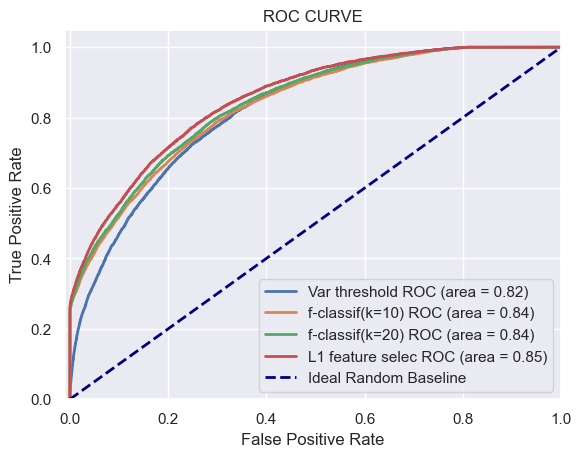

In [43]:
plt.figure()
lw = 2
plt.plot(roc_list[0][0],roc_list[0][1],lw=lw,label="Var threshold ROC (area = %0.2f)" % roc_list[0][2])
plt.plot(roc_list[1][0],roc_list[1][1],lw=lw,label="f-classif(k=10) ROC (area = %0.2f)" % roc_list[1][2])
plt.plot(roc_list[2][0],roc_list[2][1],lw=lw,label="f-classif(k=20) ROC (area = %0.2f)" % roc_list[2][2])
plt.plot(roc_list[3][0],roc_list[3][1],lw=lw,label="L1 feature selec ROC (area = %0.2f)" % roc_list[3][2])
plt.plot([0, 1], [0, 1], color="navy", lw=lw, label="Ideal Random Baseline",linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right")
experiment.log_figure(figure_name='ROC Curve for different feature selection', step=None)
plt.savefig('fs_roc.png')
plt.show()

### Final classifier

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'eta': [0.1, 0.2, 0.4],
    'max_depth': [5, 6, 7],
    'subsample': [0.6, 0.8, 1.0],
    'booster': ['gbtree', 'gblinear']
}
search = GridSearchCV(xgb_l1, param_grid, n_jobs=2, scoring='roc_auc', verbose=2)
search.fit(features, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.1,
                                     eval_metric=None, feature_types=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.100000...
                                     max_cat_threshold=64, max_cat_to_onehot=4,
                                     max_delta_step=0, max_depth=7,
                                     max_leaves=0, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto', ...),
             n_jobs=2,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'eta': [0.1, 0.2, 0.4], 'max_depth': [5, 6, 7],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [46]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.857):
{'booster': 'gbtree', 'eta': 0.1, 'max_depth': 7, 'subsample': 1.0}


In [53]:
xgb_best = xgb.XGBClassifier(eta= 0.1, max_depth=7)

# Fit
xgb_best.fit(features, y_train)

# Predict
preds = xgb_best.predict(val_features)

experiment.log_metric('accuracy with f_classif', accuracy_score(y_val, preds))
experiment.log_metric('f1 score with f_classif', f1_score(y_val, preds))
experiment.log_metric('ROC AUC score with f_classif', roc_auc_score(y_val, preds))

# accuracy_score(y_val, preds)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


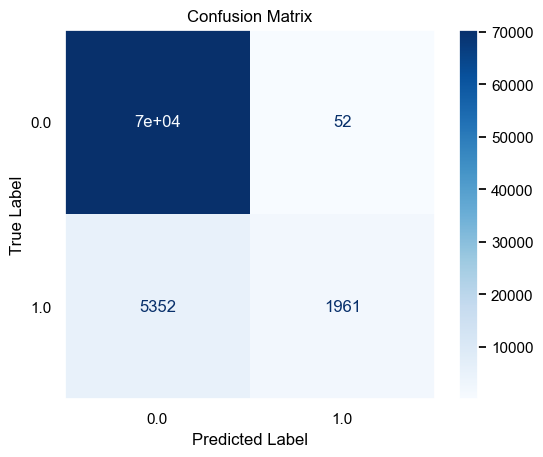

In [54]:
from sklearn.metrics import plot_confusion_matrix
 
color = 'black'
matrix = plot_confusion_matrix(xgb_best, val_features, y_val, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.grid(False)
experiment.log_figure('Confusion matrix of Best XGBoost model', step=None)
plt.show()

In [48]:
predicted_prob_fs_cv = xgb_best.predict_proba(val_features)

# Compute ROC curve and ROC area for each class
n_classes = 2
fpr_fs_cv = dict()
tpr_fs_cv = dict()
roc_auc_fs_cv = dict()

# Compute micro-average ROC curve and ROC area
fpr_fs_cv["micro"], tpr_fs_cv["micro"], _ = roc_curve(y_val, predicted_prob_fs_cv[:,1])
roc_auc_fs_cv["micro"] = auc(fpr_fs_cv["micro"], tpr_fs_cv["micro"])

# Compute goal rate and cumulative goal rate
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))

df_prob_fs_cv = pd.DataFrame(list(zip(preds,y_val['goal'],predicted_prob_fs_cv[:,1]*100)), columns = ['goal_pred', 'goal','goal_Prob'])
df_prob_fs_cv['shot'] = 1
sum_goal = df_prob_fs_cv['goal'].sum()
df_prob_fs_cv['percentile'] = df_prob_fs_cv['goal_Prob'].rank(pct=True) * 100
df_prob_fs_cv['goal_perc_bins'] = pd.cut(df_prob_fs_cv['percentile'], bins, labels = bin_centers)
df_prob_bined_fs_cv = df_prob_fs_cv[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined_fs_cv['goal_rate'] = (df_prob_bined_fs_cv['goal']/df_prob_bined_fs_cv['shot'])
df_prob_bined_fs_cv['goal_cum'] = (df_prob_bined_fs_cv['goal']/sum_goal)
df_prob_bined_fs_cv['goal_cumsum'] = 1-df_prob_bined_fs_cv['goal_cum'].cumsum()

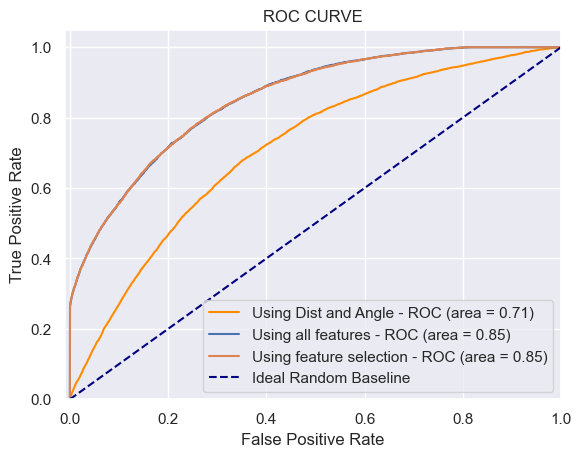

In [49]:
plt.figure()
lw = 1.5
plt.plot(
    fpr_da["micro"],
    tpr_da["micro"],
    color="darkorange",
    lw=lw,
    label="Using Dist and Angle - ROC (area = %0.2f)" % roc_auc_da["micro"],
)
plt.plot(
    fpr_cv["micro"],
    tpr_cv["micro"],
    # color="darkorange",
    lw=lw,
    label="Using all features - ROC (area = %0.2f)" % roc_auc_cv["micro"],
)
plt.plot(
    fpr_fs_cv["micro"],
    tpr_fs_cv["micro"],
    # color="darkorange",
    lw=lw,
    label="Using feature selection - ROC (area = %0.2f)" % roc_auc_fs_cv["micro"],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, label="Ideal Random Baseline",linestyle="--")
plt.xlim([-0.010, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.legend(loc="lower right")
experiment.log_figure('ROC Curve')
plt.show()

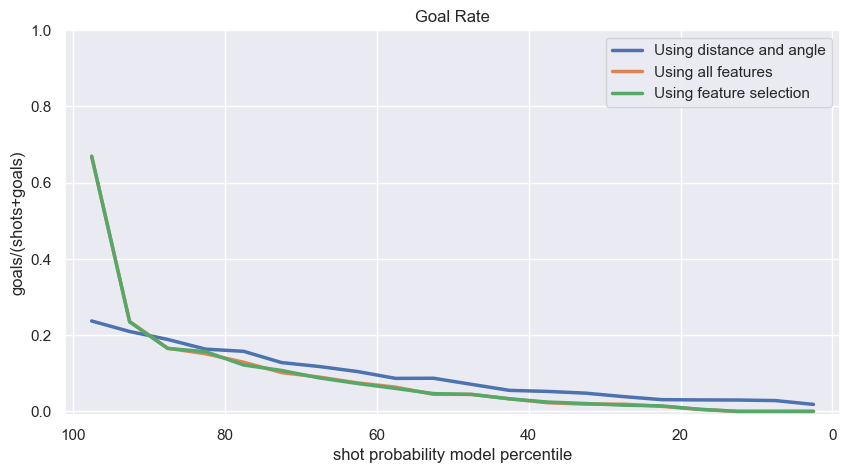

[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.6; total time=   9.9s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.6; total time=  10.2s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.8; total time=  10.1s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.8; total time=  10.1s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=0.8; total time=  10.7s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=1.0; total time=  10.2s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=1.0; total time=  10.3s
[CV] END booster=gbtree, eta=0.1, max_depth=5, subsample=1.0; total time=  10.3s
[CV] END booster=gbtree, eta=0.1, max_depth=6, subsample=0.6; total time=  14.7s
[CV] END booster=gbtree, eta=0.1, max_depth=6, subsample=0.6; total time=  14.9s
[CV] END booster=gbtree, eta=0.1, max_depth=6, subsample=0.8; total time=  14.6s
[CV] END booster=gbtree, eta=0.1, max_depth=6, subsample=0.8; total time=  14.3s
[CV] END booster=gbtree, eta

In [50]:
fig = plt.figure(figsize = (10,5))
plt.title(f"Goal Rate")
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined_da, 
                 legend = False, linewidth = 2.5, label = 'Using distance and angle')
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined_cv, 
                 legend = False, linewidth = 2.5, label = 'Using all features')
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_rate', data = df_prob_bined_fs_cv, 
                 legend = False, linewidth = 2.5, label = 'Using feature selection')
# fig.legend(loc="upper right")
plt.xlabel('shot probability model percentile')
plt.ylabel('goals/(shots+goals)')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=-0.01, top=1)
plt.xticks(np.arange(0,120,20))
plt.legend()
experiment.log_figure('Goal rate', step=None)
plt.show()

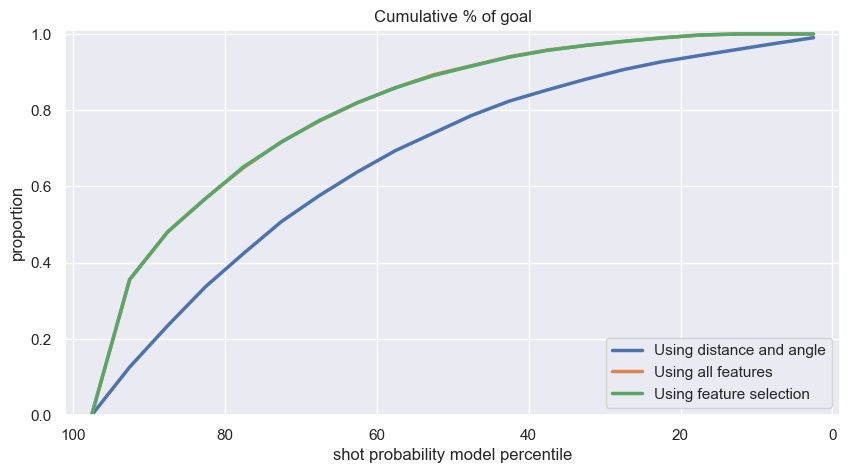

In [55]:
fig = plt.figure(figsize = (10,5))
plt.title(f"Cumulative % of goal")
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined_da, 
                 legend = False, linewidth = 2.5, label = 'Using distance and angle')
ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined_cv, 
                 legend = False, linewidth = 2.5, label = 'Using all features')

ax = sn.lineplot(x = 'goal_perc_bins', y = 'goal_cumsum', data = df_prob_bined_fs_cv, 
                 legend = False, linewidth = 2.5, label = 'Using feature selection')
# fig.legend(loc="upper right")
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
ax.set_xlim(left=101, right=-1)
ax.set_ylim(bottom=0, top=1.01)
plt.xticks(np.arange(0,120,20))
plt.legend(loc='lower right')
experiment.log_figure('Cumulative goal % Best XGBoost model', step=None)
plt.show()

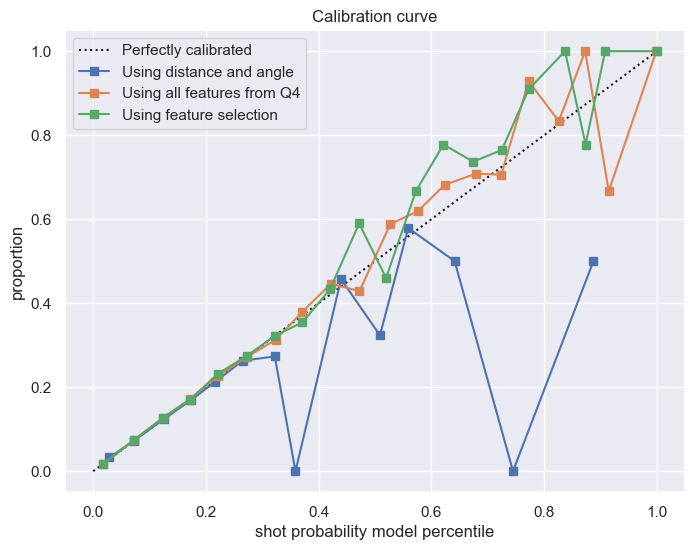

In [56]:
fig = plt.figure(figsize = (8,6))
plt.title(f"Calibration curve")
prob_true_fs_cv, prob_pred_fs_cv = calibration_curve(df_prob_fs_cv['goal'], df_prob_fs_cv['goal_Prob']/100, n_bins=20)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(prob_pred_da, prob_true_da, "s-",label='Using distance and angle')
plt.plot(prob_pred_cv, prob_true_cv, "s-",label='Using all features from Q4')
plt.plot(prob_pred_fs_cv, prob_true_fs_cv, "s-",label='Using feature selection')
plt.xlabel('shot probability model percentile')
plt.ylabel('proportion')
plt.legend(loc="upper left")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
plt.xticks(np.arange(0,1.2,0.2))
plt.yticks(np.arange(0,1.2,0.2))
plt.legend()
experiment.log_figure('Calibration curve - Best XGBoost model', step=None)
plt.show()

In [57]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
pickle.dump(xgb_best, open('models/xgb_best.sav', 'wb'))
experiment.log_model("XGB_best", 'models/xgb_best.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=1fac3d57e96f4fb1b89c7ddf39fc1247&experimentKey=5a0f6b7429074bd6adf056f184519c30',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=1fac3d57e96f4fb1b89c7ddf39fc1247&experimentKey=5a0f6b7429074bd6adf056f184519c30',
 'assetId': '1fac3d57e96f4fb1b89c7ddf39fc1247'}

In [58]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-22-team2/nhl-analytics/5a0f6b7429074bd6adf056f184519c30
COMET INFO:   Metrics:
COMET INFO:     ROC AUC score L1 feature selection : 0.6337072935478669
COMET INFO:     ROC AUC score with f_classif       : 0.6337072935478669
COMET INFO:     ROC AUC score with f_classif k=10  : 0.6277151710261901
COMET INFO:     ROC AUC score with f_classif k=20  : 0.6277151710261901
COMET INFO:     ROC AUC score with var threshold   : 0.5680293394565731
COMET INFO:     accuracy with L1 feature selection : 0.9305148382451268
COMET INFO:     accuracy with f_classif            : 0.9305148382451268
COMET INFO:     accuracy with f_classif k=10       : 0.9298719333436198
COMET INFO:     accuracy with f_classif k=20       : 0.9298719333436198
COMET INFO:     accur